# Stochastic Modeling Group 4186 GWP1

# Step 1

Let's start by importing the necessary libraries :

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

from scipy.integrate import quad
from scipy.optimize import brute, fmin
from scipy.interpolate import splev, splrep

Also, we will need to store the options data given into a table so we can use them later.

In [110]:
from google.colab import files
uploaded = files.upload()

Saving MScFE 622_Stochastic Modeling_GWP1_Option data.csv to MScFE 622_Stochastic Modeling_GWP1_Option data (6).csv


In [111]:
uploaded

{'MScFE 622_Stochastic Modeling_GWP1_Option data (6).csv': b'Days to maturity,Strike,Price,Type\r\n15,227.5,10.52,C\r\n15,230,10.05,C\r\n15,232.5,7.75,C\r\n15,235,6.01,C\r\n15,237.5,4.75,C\r\n60,227.5,16.78,C\r\n60,230,17.65,C\r\n60,232.5,16.86,C\r\n60,235,16.05,C\r\n60,237.5,15.10,C\r\n120,227.5,27.92,C\r\n120,230,24.12,C\r\n120,232.5,22.97,C\r\n120,235,21.75,C\r\n120,237.5,18.06,C\r\n15,227.5,4.32,P\r\n15,230,5.20,P\r\n15,232.5,6.45,P\r\n15,235,7.56,P\r\n15,237.5,8.78,P\r\n60,227.5,11.03,P\r\n60,230,12.15,P\r\n60,232.5,13.37,P\r\n60,235,14.75,P\r\n60,237.5,15.62,P\r\n120,227.5,14.53,P\r\n120,230,16.25,P\r\n120,232.5,17.22,P\r\n120,235,18.74,P\r\n120,237.5,19.73,P'}

In [112]:
data = pd.read_csv(io.BytesIO(uploaded['MScFE 622_Stochastic Modeling_GWP1_Option data (6).csv']))
print(data)

    Days to maturity  Strike  Price Type
0                 15   227.5  10.52    C
1                 15   230.0  10.05    C
2                 15   232.5   7.75    C
3                 15   235.0   6.01    C
4                 15   237.5   4.75    C
5                 60   227.5  16.78    C
6                 60   230.0  17.65    C
7                 60   232.5  16.86    C
8                 60   235.0  16.05    C
9                 60   237.5  15.10    C
10               120   227.5  27.92    C
11               120   230.0  24.12    C
12               120   232.5  22.97    C
13               120   235.0  21.75    C
14               120   237.5  18.06    C
15                15   227.5   4.32    P
16                15   230.0   5.20    P
17                15   232.5   6.45    P
18                15   235.0   7.56    P
19                15   237.5   8.78    P
20                60   227.5  11.03    P
21                60   230.0  12.15    P
22                60   232.5  13.37    P
23              

In [113]:
options15 = data[data['Days to maturity'] == 15]
options15.head()

,Days to maturity,Strike,Price,Type
0,15,227.5,10.52,C
1,15,230.0,10.05,C
2,15,232.5,7.75,C
3,15,235.0,6.01,C
4,15,237.5,4.75,C


## Student A: Pricing with Heston (1993) via Lewis (2001)


First of all, we will need to define the initial parameters of the Heston (1993) model that we will calibrate. We also apply the given parameters to the stock.

In [114]:
# Option Parameters
S0 = 232.90        # current price of stock SM
K = 100.0
#T = 15/250         # 15 days left to expiration  # lois : Shouldn't you divide with 250 ? (15/250)
r = 0.015          # constant annual risk-free rate of 1.50%


# example Heston(1993) Parameters
kappa_v = 1.5
theta_v = 0.02
sigma_v = 0.15
rho = 0.1
v0 = 0.01


### Heston Model Calibration

#### Mean Squared Error (MSE) function

The first step in the calibration of Heston model is to introduce a function that will evaluate the error the model makes with respect to the observed data.

In [115]:
i = 0
min_MSE = 500

In [116]:
def H93_error_function(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options15.iterrows():
        if option["Type"] == "C":
            model_value= H93_call_value(S0, option['Strike'], option["Days to maturity"]/250, r, kappa_v, theta_v, sigma_v, rho, v0)
            se.append(model_value)

        if option["Type"] == "P":
            model_value = H93_put_value_parity(H93_call_value(S0, option['Strike'], option["Days to maturity"]/250, r, kappa_v, theta_v, sigma_v, rho, v0),
                                              r, option['Strike'], option["Days to maturity"]/250)
            se.append(model_value)


        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

#### Calculating the Value of the Call and Put

In [117]:
def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)

    Parameter definition:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    Returns
    =======
    call_value: float
        present value of European call option
    """
    int_value = quad(
        lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

#### Integral Value in Lewis (2001)

In [118]:
def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Fourier-based approach for Lewis (2001): Integration function.
    """
    char_func_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

#### Heston (1993) Characteristic Function

In [119]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

Using Put-Call parity to get the Put price for HESTON (1993)

In [120]:
# Put-Call parity to get the Put price
def H93_put_value_parity(call_value,r,K,T):
    return H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0) - S0 + np.exp(-r*T) * K


#### Optimization process

Final step of the model calibration is to optimize the model parameters. What we are trying to do is to minimize the error function with respect to model parameters.

In [121]:
def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (1.0, 10.6, 1.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.01, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.1),  # rho
            (0.01, 0.031, 0.01), # v0
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=950, maxfun=900
    )
    return opt

In [122]:
kappa_v, theta_v, sigma_v, rho, v0 = H93_calibration_full()

   0 | [ 1.    0.01  0.01 -0.75  0.01] |  11.342 |  11.342
 100 | [ 1.    0.03  0.01 -0.65  0.02] |   9.686 |   8.667
 200 | [ 1.    0.04  0.11 -0.55  0.03] |   8.639 |   8.636
 300 | [ 2.    0.02  0.01 -0.35  0.01] |  11.226 |   8.636
 400 | [ 2.    0.03  0.11 -0.25  0.02] |   9.652 |   8.636
 500 | [ 2.    0.04  0.21 -0.15  0.03] |   8.629 |   8.612
 600 | [ 3.    0.02  0.11 -0.75  0.01] |  11.163 |   8.612
 700 | [ 3.    0.03  0.21 -0.65  0.02] |   9.616 |   8.612
 800 | [ 4.    0.01  0.01 -0.55  0.03] |   8.868 |   8.589
 900 | [ 4.    0.02  0.11 -0.35  0.01] |  11.120 |   8.589
1000 | [ 4.    0.03  0.21 -0.25  0.02] |   9.595 |   8.589
1100 | [ 5.    0.01  0.01 -0.15  0.03] |   8.917 |   8.567
1200 | [ 5.    0.02  0.21 -0.75  0.01] |  11.071 |   8.567
1300 | [ 5.    0.04  0.01 -0.65  0.02] |   9.394 |   8.552
1400 | [ 6.    0.01  0.11 -0.55  0.03] |   8.959 |   8.546
1500 | [ 6.    0.02  0.21 -0.35  0.01] |  11.035 |   8.546
1600 | [ 6.    0.04  0.01 -0.25  0.02] |   9.340 |   8.5

<ipython-input-121-c5bd5466bfe0>:19: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt = fmin(


In [123]:
print(" %4.3f |  %4.3f | %4.3f | %4.3f | %4.3f" % (kappa_v, theta_v, sigma_v, rho, v0))

 50.527 |  0.005 | 0.711 | -0.895 | 0.282


### Ploting the calibration results

<ipython-input-124-49e749c5d0fa>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Model"] = H93_model_values( kappa_v, theta_v, sigma_v, rho, v0 )


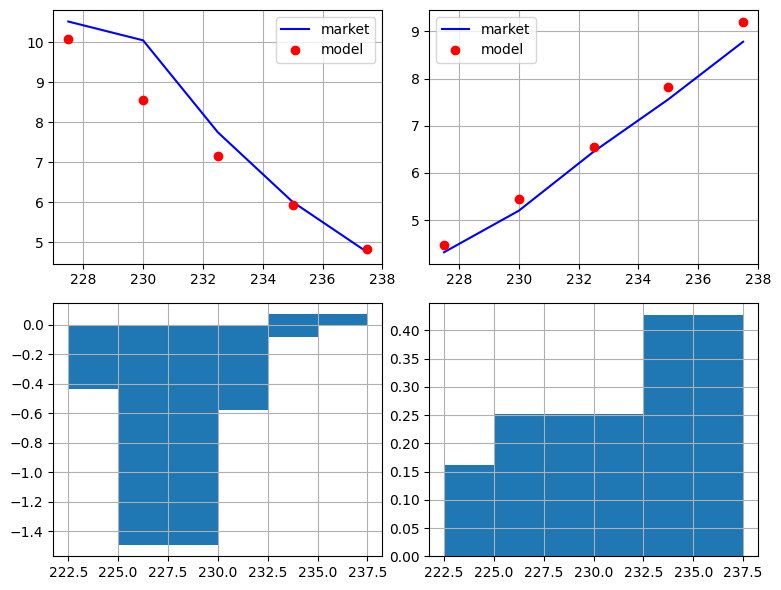

In [124]:


def H93_model_values( kappa_v, theta_v, sigma_v, rho, v0 ):

    """
  using vector p0, calculates all model values (both Calls and Puts)
  """

    #kappa_v, theta_v, sigma_v, rho, v0 = p0
    values=[]

    for row, option in options15.iterrows():
        if option['Type'] == 'C':

            model_value = H93_call_value(S0, option["Strike"], option["Days to maturity"]/250, r, kappa_v, theta_v, sigma_v, rho, v0 )

        if option['Type']  == 'P':
            model_value = H93_put_value_parity(H93_call_value(S0, option["Strike"], option["Days to maturity"]/250, r, kappa_v, theta_v, sigma_v, rho, v0),
                                         r, option["Strike"], option["Days to maturity"]/250)
        values.append(model_value)

    return np.array(values)


options = options15

def plot_calibration_results_H93(kappa_v, theta_v, sigma_v, rho, v0):
    options["Model"] = H93_model_values( kappa_v, theta_v, sigma_v, rho, v0 )
    plt.figure(figsize=(8,6))
    calls = options[options["Type"] == "C"]
    puts = options[options["Type"] == "P"]
    plt.subplot(221)
    plt.grid()
    plt.plot(calls.Strike, calls.Price, 'b', label='market')
    plt.plot(calls.Strike, calls.Model, 'ro', label='model')
    plt.legend(loc=0)
    plt.subplot(223)
    plt.grid()
    wi = 5.0
    diff_calls = calls.Model.values - calls.Price.values
    plt.bar(calls.Strike.values - wi/2, diff_calls, width=wi)
    plt.subplot(222)
    plt.grid()
    plt.plot(puts.Strike, puts.Price, 'b', label='market')
    plt.plot(puts.Strike, puts.Model, 'ro', label='model')
    plt.legend(loc=0)
    plt.subplot(224)
    plt.grid()
    wi=5.0
    diff_puts = puts.Model.values - puts.Price.values
    plt.bar(puts.Strike.values - wi/2, diff_puts, width=wi)
    plt.tight_layout()


plot_calibration_results_H93(kappa_v, theta_v, sigma_v, rho, v0)


## Student C: Price a call option using the calibrated parameters

#### i. Obtain the ‘fair price’ of the instrument using Monte-Carlo methods in a risk-neutral setting.

First, we will set the option parameters. The client wants an ATM Asian option with 20 days maturity. Therefore, we will have to modify the time period. We will use the parameters of the calibrated Heston model created earlier.

In [190]:
# initial inputs

# Stock parameters
S0 = 232.90   # Stock price
K = S0        # ATM strike price
T = 20/250    # Maturity
r = 0.015     # Risk-free rate

# Monte-Carlo parameters
Ite = 100000     # Number of simulations
M = 5         # Number of total time steps
dt = T / M      # Period between each step

##### Stochastic volatility

In [191]:
def SDE_vol(v0, kappa, theta, sigma, T, M, Ite, rand, row, cho_matrix):
    dt = T / M  # T = maturity, M = number of time steps
    v = np.zeros((M + 1, Ite), dtype=np.float)
    v[0] = v0
    sdt = np.sqrt(dt)  # Sqrt of dt
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        v[t] = np.maximum(
            0,
            v[t - 1]
            + kappa * (theta - v[t - 1]) * dt
            + np.sqrt(v[t - 1]) * sigma * ran[row] * sdt,
        )
    return v

##### Calculation the underlying stock price of an Asian option

In [192]:
def Heston_paths(S0, r, v, row, cho_matrix):
    S = np.zeros((M + 1, Ite), dtype=float)
    S[0] = S0
    sdt = np.sqrt(dt)
    for t in range(1, M + 1, 1):
        ran = np.dot(cho_matrix, rand[:, t])
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[row] * sdt)

    return S

##### Build the covariance matrix

Generate random numbers:

In [193]:
np.random.seed(42)

def random_number_gen(M, Ite):
    rand = np.random.standard_normal((2, M + 1, Ite))
    return rand

rand = random_number_gen(M, Ite)

Covariance Matrix :

In [194]:
covariance_matrix = np.zeros((2, 2), dtype=np.float)
covariance_matrix[0] = [1.0, rho]
covariance_matrix[1] = [rho, 1.0]
cho_matrix = np.linalg.cholesky(covariance_matrix)

<ipython-input-194-6ac8bc66d8d9>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  covariance_matrix = np.zeros((2, 2), dtype=np.float)


##### Calculate stock price paths and stochastic volatility

In [195]:
# Volatility process paths
V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, Ite, rand, 1, cho_matrix)

# Underlying price process paths
S = Heston_paths(S0, r, V, 0, cho_matrix)

<ipython-input-191-480f2acb094e>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  v = np.zeros((M + 1, Ite), dtype=np.float)


In [196]:
V

array([[0.00653575, 0.00653575, 0.00653575, ..., 0.00653575, 0.00653575,
        0.00653575],
       [0.01100044, 0.00419386, 0.01089758, ..., 0.01310859, 0.01189896,
        0.00854582],
       [0.02379728, 0.00774226, 0.00769095, ..., 0.010075  , 0.01280112,
        0.01092536],
       [0.03376448, 0.01230155, 0.        , ..., 0.01451946, 0.02499754,
        0.01373633],
       [0.05977776, 0.01127264, 0.00275414, ..., 0.0113731 , 0.0147341 ,
        0.01936445],
       [0.03788175, 0.00377151, 0.01060635, ..., 0.02529879, 0.01069289,
        0.02016012]])

Ploting the Monte-Carlo simulations

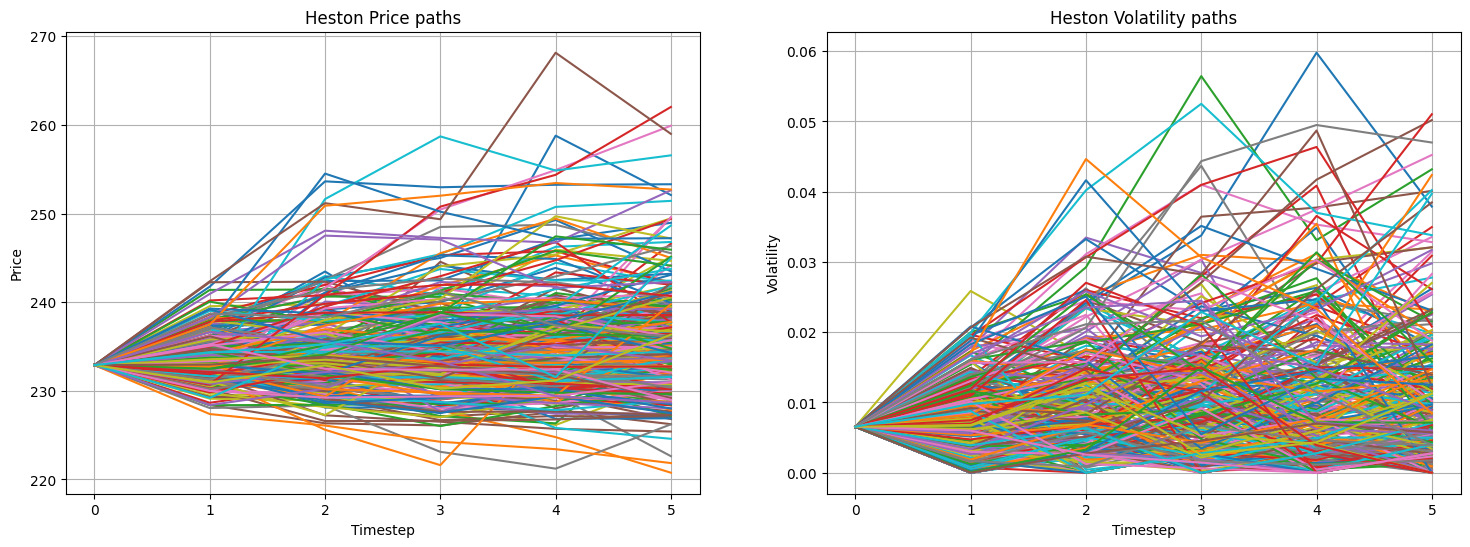

In [197]:
def plot_paths(n):
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(range(len(S)), S[:, :n])
    ax1.grid()
    ax1.set_title("Heston Price paths")
    ax1.set_ylabel("Price")
    ax1.set_xlabel("Timestep")

    ax2.plot(range(len(V)), V[:, :n])
    ax2.grid()
    ax2.set_title("Heston Volatility paths")
    ax2.set_ylabel("Volatility")
    ax2.set_xlabel("Timestep")


plot_paths(300)

##### Price the Asian call option



We will average all the price paths to obtain the estimated price of an Asian type option:

In [133]:
S = np.mean(S)
S

233.03982387754763

In [134]:
def heston_call_mc(S, K, r, T):
    payoff = np.maximum(0, S - K)

    average = np.mean(payoff)

    return np.exp(-r * (T)) * average

In [135]:
Asian_call = round(heston_call_mc(S, K, r, T), 3)
Asian_call

0.14

#### ii. As part of the bank’s profit, you charge a 4% fee on the price to obtain the final price that the client will end up paying.

In [136]:
Asian_call_client = round(Asian_call * 1.04, 3)
Asian_call_client

0.146

# Step 2

## Student C

Team member C will now repeat Task (a) in Step 1 for the new case at hand
(60-day maturity instrument) using a Heston model with jumps (i.e., Bates, 1996
model).

In [137]:
options60 = data[data['Days to maturity'] == 60]
options60.head()

,Days to maturity,Strike,Price,Type
5,60,227.5,16.78,C
6,60,230.0,17.65,C
7,60,232.5,16.86,C
8,60,235.0,16.05,C
9,60,237.5,15.10,C


### Calibratin Heston with 60 day maturity oprions

First, we will use the Heston (1996) model to obtain the parameters of stochastic volatility. We will use an error function that will eliminate the differene between the estimated parameters and the market data.

In [138]:
# Option Parameters
S0 = 232.90        # Current price of stock SM
K = 100.0         # Strike price
#T = 60/250        # 60 days left to expiration
r = 0.015          # Constant annual risk-free rate of 1.50%


# Set-up Heston(1993) initial Parameters
kappa_v = 1.0
theta_v = 0.01
sigma_v = 0.1
rho = 0.1
v0 = 0.01

# Example Merton parameters
lamb = 0
mu = -0.5
delta = 0

i = 0
min_MSE = 500

def H93_error_function_60(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options60.iterrows():
        if option["Type"] == "C":
            model_value= H93_call_value(S0, option['Strike'], option["Days to maturity"]/250, r, kappa_v, theta_v, sigma_v, rho, v0)
            se.append(model_value)

        if option["Type"] == "P":
            model_value = H93_put_value_parity(H93_call_value(S0, option['Strike'], option["Days to maturity"]/250, r, kappa_v, theta_v, sigma_v, rho, v0),
                                              r, option['Strike'], option["Days to maturity"]/250)
            se.append(model_value)


        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE


def H93_calibration_full_60():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function_60,
        (
            (1.0, 10.6, 1.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.01, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.1),  # rho
            (0.01, 0.031, 0.01),  # v0
        ),
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function_60, p0, xtol=0.000001, ftol=0.000001, maxiter=950, maxfun=900
    )
    return opt


kappa_v, theta_v, sigma_v, rho, v0 = H93_calibration_full()
print(" %4.3f |  %4.3f | %4.3f | %4.3f | %4.3f" % (kappa_v, theta_v, sigma_v, rho, v0))





   0 | [ 1.    0.01  0.01 -0.75  0.01] |  11.409 |  11.409
 100 | [ 1.    0.03  0.01 -0.65  0.02] |   9.752 |   8.734
 200 | [ 1.    0.04  0.11 -0.55  0.03] |   8.705 |   8.702
 300 | [ 2.    0.02  0.01 -0.35  0.01] |  11.293 |   8.702
 400 | [ 2.    0.03  0.11 -0.25  0.02] |   9.719 |   8.702
 500 | [ 2.    0.04  0.21 -0.15  0.03] |   8.696 |   8.678
 600 | [ 3.    0.02  0.11 -0.75  0.01] |  11.230 |   8.678
 700 | [ 3.    0.03  0.21 -0.65  0.02] |   9.682 |   8.678
 800 | [ 4.    0.01  0.01 -0.55  0.03] |   8.935 |   8.655
 900 | [ 4.    0.02  0.11 -0.35  0.01] |  11.187 |   8.655
1000 | [ 4.    0.03  0.21 -0.25  0.02] |   9.662 |   8.655
1100 | [ 5.    0.01  0.01 -0.15  0.03] |   8.983 |   8.634
1200 | [ 5.    0.02  0.21 -0.75  0.01] |  11.138 |   8.634
1300 | [ 5.    0.04  0.01 -0.65  0.02] |   9.461 |   8.619
1400 | [ 6.    0.01  0.11 -0.55  0.03] |   9.026 |   8.613
1500 | [ 6.    0.02  0.21 -0.35  0.01] |  11.102 |   8.613
1600 | [ 6.    0.04  0.01 -0.25  0.02] |   9.407 |   8.5

<ipython-input-121-c5bd5466bfe0>:19: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt = fmin(


In [139]:

print(" %4.3f |  %4.3f | %4.3f | %4.3f | %4.3f" % (kappa_v, theta_v, sigma_v, rho, v0))

 50.527 |  0.005 | 0.711 | -0.895 | 0.282


### Ploting the new Heston calibrations results for the 60-day maturity

<ipython-input-140-2c370ddaaf7d>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Model"] = H93_model_values_60( kappa_v, theta_v, sigma_v, rho, v0 )


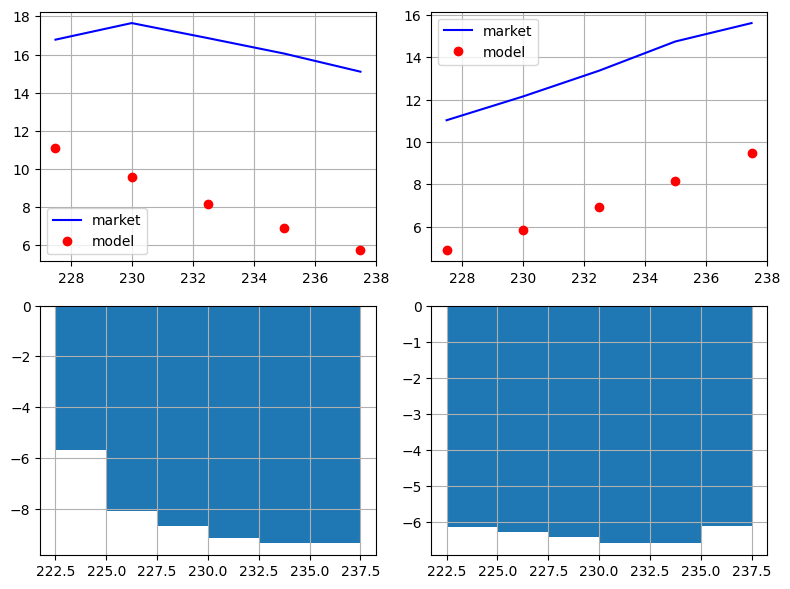

In [140]:
##################################################################################

options = options60

def H93_model_values_60(kappa_v, theta_v, sigma_v, rho, v0):

    """
  using vector p0, calculates all model values (both Calls and Puts)
  """

    #kappa_v, theta_v, sigma_v, rho, v0 = p0
    values=[]

    for row, option in options60.iterrows():
        if option['Type'] == 'C':

            model_value = H93_call_value(S0, option["Strike"], option["Days to maturity"]/250, r, kappa_v, theta_v, sigma_v, rho, v0 )

        if option['Type']  == 'P':
            model_value = H93_put_value_parity(H93_call_value(S0, option["Strike"], option["Days to maturity"]/250, r, kappa_v, theta_v, sigma_v, rho, v0),
                                         r, option["Strike"], option["Days to maturity"]/250)

        values.append(model_value)

    return np.array(values)


def plot_calibration_results_H93_60(kappa_v, theta_v, sigma_v, rho, v0):
    options["Model"] = H93_model_values_60( kappa_v, theta_v, sigma_v, rho, v0 )
    plt.figure(figsize=(8,6))
    calls = options[options["Type"] == "C"]
    puts = options[options["Type"] == "P"]
    plt.subplot(221)
    plt.grid()
    plt.plot(calls.Strike, calls.Price, 'b', label='market')
    plt.plot(calls.Strike, calls.Model, 'ro', label='model')
    plt.legend(loc=0)
    plt.subplot(223)
    plt.grid()
    wi = 5.0
    diff_calls = calls.Model.values - calls.Price.values
    plt.bar(calls.Strike.values - wi/2, diff_calls, width=wi)
    plt.subplot(222)
    plt.grid()
    plt.plot(puts.Strike, puts.Price, 'b', label='market')
    plt.plot(puts.Strike, puts.Model, 'ro', label='model')
    plt.legend(loc=0)
    plt.subplot(224)
    plt.grid()
    wi=5.0
    diff_puts = puts.Model.values - puts.Price.values
    plt.bar(puts.Strike.values - wi/2, diff_puts, width=wi)
    plt.tight_layout()


plot_calibration_results_H93_60(kappa_v, theta_v, sigma_v, rho, v0)


### Regularization of the error function

The error function of the Bates (1996) model minimizes the differences between the market and model prices.

In [141]:


# Set tolerance level for near ATM options
tol = 0.02  # percent ITM/OTM options
options = data[(np.abs(data["Strike"] - S0) / S0) < tol]

In [142]:
i = 0
min_MSE = 5000.0
local_opt = False

def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options60.iterrows():
        if option["Type"] == "C":
            model_value= B96_call_value(S0, option['Strike'], option['Days to maturity']/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            se.append(model_value)

        if option["Type"] == "P":
            model_value = B96_put_value_parity(B96_call_value(S0, option['Strike'], option['Days to maturity']/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta),
                                              r, option['Strike'], option['Days to maturity']/250)
            se.append(model_value)

        se.append((model_value - option["Price"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

### Option pricing functions

In [143]:
######################################################################################
# Option pricing functions

def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

In [144]:
# Put-Call parity to get the Put price for BATES ()
def B96_put_value_parity(a,b,c,d):
    return B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta) - S0 + np.exp(-r*T) * K


### Characteristic function

The characteristic function is used for the computation of the Lewis (2001) integral

In [145]:



#####################################################################################
# Characteristic function. The characteristic function is used for the computation of the Lewis (2001) integral

def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

### Calibration functions with jump component

It is time now to calibrate the jump component of the model:

In [146]:
def B96_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25), # delta
        ),
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

In [147]:
i = 0
min_MSE = 5000.0
local_opt = False

In [148]:
def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options60.iterrows():
        if option["Type"] == "C":
            model_value= B96_call_value(S0, option['Strike'], option['Days to maturity']/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            se.append(model_value)

        if option["Type"] == "P":
            model_value = B96_put_value_parity(B96_call_value(S0, option['Strike'], option['Days to maturity']/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta),
                                              r, option['Strike'], option['Days to maturity']/250)
            se.append(model_value)

        se.append((model_value - option["Price"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE


In [149]:
params = B96_calibration_short()

   0 | [ 0.  -0.5  0. ] |  64.755 |  64.755
  25 | [ 0.2  -0.5   0.25] |  57.874 |  57.615
  50 | [ 0.4 -0.5  0.5] |  52.467 |  52.467
  75 | [ 0.5   -0.5    0.525] |  50.959 |  50.798
 100 | [ 0.6005017  -0.41806762  0.72560204] |  50.133 |  50.098
 125 | [ 0.63819998 -0.12319514  0.63749917] |  49.851 |  49.797
 150 | [ 0.65944983 -0.00111242  0.57036249] |  49.769 |  49.769
 175 | [ 6.59168038e-01 -3.85128217e-09  5.69822863e-01] |  49.768 |  49.768
 200 | [ 6.59048093e-01 -5.82954877e-07  5.70176781e-01] |  49.768 |  49.768
 225 | [ 6.59040261e-01 -7.35905088e-10  5.70198150e-01] |  49.768 |  49.768
 250 | [ 6.59041207e-01 -5.94528853e-11  5.70195384e-01] |  49.768 |  49.768
 275 | [ 6.59041145e-01 -2.25029233e-12  5.70195565e-01] |  49.768 |  49.768
Optimization terminated successfully.
         Current function value: 49.768384
         Iterations: 165
         Function evaluations: 305


We will store the values of the obtained parameters:

In [150]:
lamb, mu, delta = params
params

array([ 6.59041140e-01, -1.30172881e-14,  5.70195580e-01])

### Full Bates (1996) calibration



For the last step of pricing using the calibrated Bates model, we will use the inputs we obtained from the stochastic volatility model, together with those from the jump component.

In [151]:
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

### Error function

In [152]:
i = 0
min_MSE = 5000.0

def B96_full_error_function(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options60.iterrows():
        if option["Type"] == "C":
            model_value= B96_call_value(S0, option['Strike'], option['Days to maturity']/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            se.append(model_value)

        if option["Type"] == "P":
            model_value = B96_put_value_parity(B96_call_value(S0, option['Strike'], option['Days to maturity']/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta),
                                              r, option['Strike'], option['Days to maturity']/250)
            se.append(model_value)

        se.append((model_value - option["Price"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

### Beta Calibration

In [153]:
def B96_calibration_full():
    opt = fmin(
        B96_full_error_function, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt

### Calculate values under full model calibration

In [154]:
def B96_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    for row, option in options60.iterrows():
        if option["Type"] == "C":
            model_value= B96_call_value(S0, option['Strike'], option['Days to maturity']/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)


        if option["Type"] == "P":
            model_value = B96_put_value_parity(B96_call_value(S0, option['Strike'], option['Days to maturity']/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta),
                                              r, option['Strike'], option['Days to maturity']/250)


        values.append((model_value - option["Price"]) ** 2)



    return np.array(values)

In [155]:
full_params = B96_calibration_full()

   0 | [ 5.05266947e+01  5.00000015e-03  7.10658355e-01 -8.94869360e-01
  2.82005849e-01  6.59041140e-01 -1.30172881e-14  5.70195580e-01] |  49.236 |  49.236
 100 | [ 1.21239653e+02  1.02453762e-02  5.99798272e-01  8.73813332e-01
  7.04348650e-03  4.57319481e-01 -2.64246726e-14  8.16416872e-01] |  49.104 |  49.102
 200 | [ 1.13434456e+02  1.09980741e-02  6.55330312e-01  7.52065509e-01
  5.10035234e-03  3.86465522e-01 -2.39126339e-14  8.97050372e-01] |  49.099 |  49.099
 300 | [ 7.45232580e+01  1.21205448e-02  7.75553510e-01  4.62674329e-01
  1.75077702e-02  2.85947567e-01 -1.66001709e-14  1.03718120e+00] |  49.096 |  49.096
 400 | [ 4.67275792e+01  1.27209494e-02  8.37987200e-01  2.78655081e-01
  2.48408560e-02  2.44879965e-01 -1.20498076e-14  1.10742218e+00] |  49.095 |  49.095
 500 | [ 2.08456569e+01  1.46287697e-02  6.79857500e-01  5.14882023e-01
  1.04456311e-02  2.17202897e-01 -9.81067086e-15  1.16164440e+00] |  49.090 |  49.090


<ipython-input-153-0fb35a4aa397>:2: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt = fmin(


In [156]:
full_params

array([ 1.13079876e+01,  1.52223383e-02,  5.86169419e-01,  6.68698832e-01,
        6.53575054e-03,  2.16902905e-01, -9.57366738e-15,  1.16760632e+00])

In [157]:
kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = full_params

print(" %4.3f |  %4.3f | %4.3f | %4.3f | %4.3f | %4.3f | %4.3f | %4.3f " % (kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta))

 11.308 |  0.015 | 0.586 | 0.669 | 0.007 | 0.217 | -0.000 | 1.168 


### Ploting the Bates 96 calibrations results

<ipython-input-158-a746d628f4f1>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_bates["Model"] = B96_model_values_60( full_params )


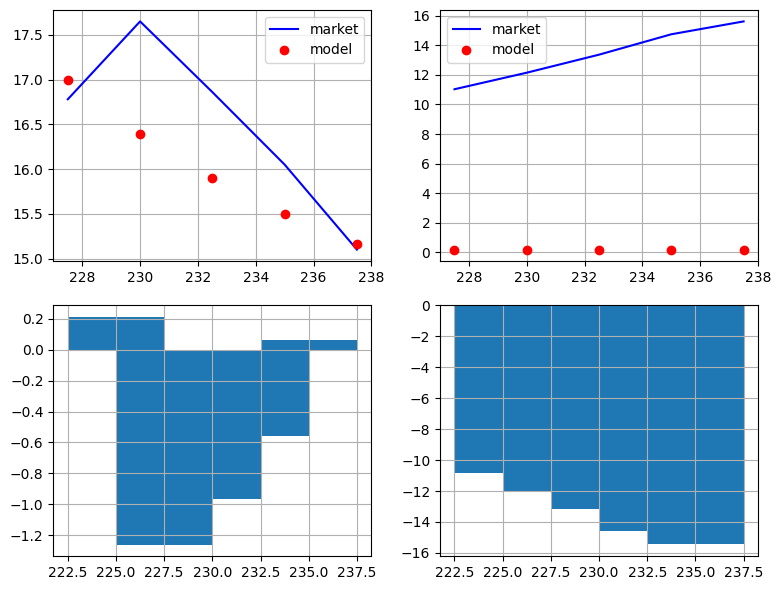

In [158]:
options_bates = options60

def B96_model_values_60(full_params):

    """
  using vector p0, calculates all model values (both Calls and Puts)
  """

    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = full_params
    values=[]

    for row, option in options60.iterrows():
        if option["Type"] == "C":
            model_value= B96_call_value(S0, option['Strike'], option['Days to maturity']/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)


        if option["Type"] == "P":
            model_value = B96_put_value_parity(B96_call_value(S0, option['Strike'], option['Days to maturity']/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta),
                                              r, option['Strike'], option['Days to maturity']/250)

        values.append(model_value)

    return np.array(values)


def plot_calibration_results_B96_60(full_params):
    options_bates["Model"] = B96_model_values_60( full_params )
    plt.figure(figsize=(8,6))
    calls = options_bates[options_bates["Type"] == "C"]
    puts = options_bates[options_bates["Type"] == "P"]
    plt.subplot(221)
    plt.grid()
    plt.plot(calls.Strike, calls.Price, 'b', label='market')
    plt.plot(calls.Strike, calls.Model, 'ro', label='model')
    plt.legend(loc=0)
    plt.subplot(223)
    plt.grid()
    wi = 5.0
    diff_calls = calls.Model.values - calls.Price.values
    plt.bar(calls.Strike.values - wi/2, diff_calls, width=wi)
    plt.subplot(222)
    plt.grid()
    plt.plot(puts.Strike, puts.Price, 'b', label='market')
    plt.plot(puts.Strike, puts.Model, 'ro', label='model')
    plt.legend(loc=0)
    plt.subplot(224)
    plt.grid()
    wi=5.0
    diff_puts = puts.Model.values - puts.Price.values
    plt.bar(puts.Strike.values - wi/2, diff_puts, width=wi)
    plt.tight_layout()


plot_calibration_results_B96_60(full_params)


## Student A: calibrating Carr-Madan(1999) approach to Bates (1996) model


In [159]:
def B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Call option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

In [160]:
i = 0
min_MSE = 5000.0

def B96_full_error_function_carr_madan(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options60.iterrows():
        if option["Type"] == "C":
            model_value= B96_call_FFT(S0, option['Strike'], option['Days to maturity']/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            se.append(model_value)

        if option["Type"] == "P":
            model_value = B96_put_value_parity(B96_call_FFT(S0, option['Strike'], option['Days to maturity']/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta),
                                              r, option['Strike'], option['Days to maturity']/250)
            se.append(model_value)

        se.append((model_value - option["Price"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [161]:
i = 0
min_MSE = 5000.0

def B96_full_error_function_carr_madan(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options60.iterrows():
        if option["Type"] == "C":
            model_value= B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            se.append(model_value)

        if option["Type"] == "P":
            model_value = B96_put_value_parity(B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta),
                                              r, option['Strike'], T)
            se.append(model_value)

        se.append((model_value - option["Price"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [162]:
def B96_calibration_short_carr_madan():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_full_error_function_carr_madan,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25), # delta
        ),
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_full_error_function_carr_madan,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

In [163]:
params_carr_madan = B96_calibration_short()
lamb, mu, delta = params_carr_madan



   0 | [ 0.  -0.5  0. ] |  76.002 |  76.002
  25 | [ 0.2  -0.5   0.25] |  66.655 |  66.264
  50 | [ 0.4 -0.5  0.5] |  57.347 |  57.347
  75 | [ 5.0e-01 -5.0e-01  2.5e-04] |  54.013 |  53.289
 100 | [ 7.27449131e-01 -5.21087677e-01  4.58247599e-04] |  49.654 |  49.647
 125 | [ 1.00751032e+00 -3.63839171e-01  7.76338452e-04] |  49.641 |  49.509
 150 | [ 1.29309975 -0.32802965  0.00131764] |  49.375 |  49.304
 175 | [ 2.24522678 -0.20988299  0.00282469] |  49.024 |  49.024
 200 | [ 3.4497101  -0.16835156  0.00501081] |  48.896 |  48.804
 225 | [ 3.70132796 -0.17241861  0.00550425] |  48.772 |  48.772
 250 | [ 3.81080728 -0.17014647  0.00571378] |  48.771 |  48.771
 275 | [ 3.80945934 -0.17015232  0.00569828] |  48.771 |  48.771
 300 | [ 3.78342415 -0.17083032  0.00456551] |  48.771 |  48.771
 325 | [ 3.76903437e+00 -1.70937086e-01  1.28568474e-03] |  48.770 |  48.770
 350 | [ 3.82574739e+00 -1.69897546e-01  5.40128044e-04] |  48.770 |  48.770
 375 | [ 3.81843851e+00 -1.70066014e-01  1.827

In [164]:
print(params_carr_madan)

[ 3.81793288e+00 -1.70077668e-01  6.31484370e-09]


### Full Bates (1996) calibration with Carr Madan

In [165]:
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

In [166]:
def B96_calibration_full():
    opt = fmin(
        B96_full_error_function_carr_madan, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt




In [167]:
full_params_carr_madan = B96_calibration_full()


 500 | [ 1.13079876e+01  1.52223383e-02  5.86169419e-01  6.68698832e-01
  6.53575054e-03  3.81793288e+00 -1.70077668e-01  6.63058588e-09] | 3473.842 |  48.770
 525 | [ 1.21237364e+01  1.61502615e-02  5.19280100e-01  6.94470999e-01
  7.14225880e-03  3.89717095e+00 -1.11794455e-01  6.93252766e-09] | 3473.841 |  48.770
 550 | [ 1.31225394e+01  1.63893135e-02  4.52690732e-01  7.28224782e-01
  7.24046395e-03  3.91630689e+00 -5.27978561e-02  7.66827848e-09] | 3473.841 |  48.770
 575 | [ 1.31968915e+01  1.61304798e-02  4.54036865e-01  7.20045574e-01
  7.38544028e-03  3.88667562e+00 -5.44910645e-02  7.64791875e-09] | 3473.841 |  48.770
 600 | [ 1.32778180e+01  1.61845835e-02  4.53149141e-01  7.15620386e-01
  7.38756548e-03  3.84682127e+00 -5.43935880e-02  7.68521752e-09] | 3473.841 |  48.770
 625 | [ 1.32451477e+01  1.61613525e-02  4.55865583e-01  7.15417943e-01
  7.38671578e-03  3.84021652e+00 -5.67661719e-02  7.67185110e-09] | 3473.841 |  48.770
 650 | [ 1.32479153e+01  1.61628923e-02  4.559

In [168]:
print(full_params_carr_madan)

[ 1.32483648e+01  1.61634107e-02  4.55987498e-01  7.15109434e-01
  7.38680081e-03  3.83711925e+00 -5.69178458e-02  7.67344659e-09]


### Ploting calibration of Bates 96 with Carr-Madam approach

<ipython-input-169-c0ef99d8a501>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options["Model"] = B96_model_values_60_Carr_Madam( params_carr_madan )


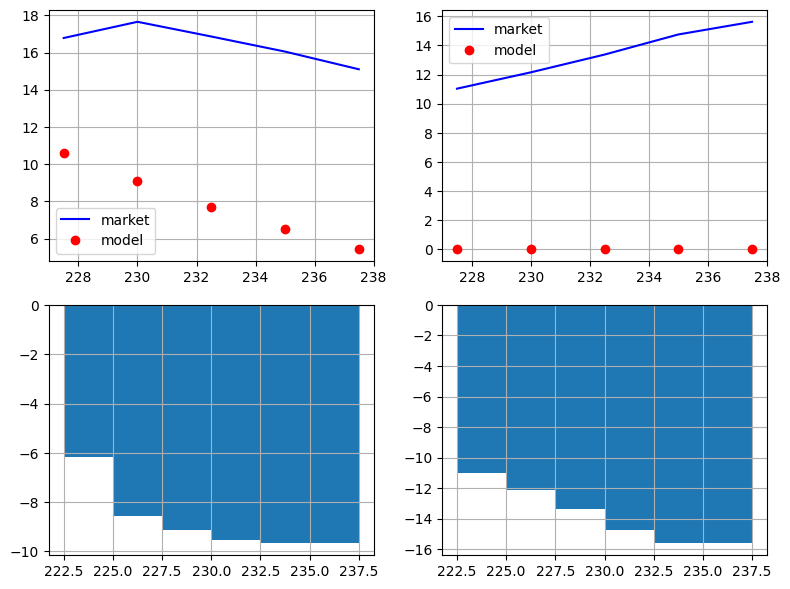

In [169]:
# ploting calibration of Bates 96 with Carr-Madam approach

# ploting the Bates 96 calibrations results

options = options60

def B96_model_values_60_Carr_Madam(full_params_carr_madan):

    """
  using vector p0, calculates all model values (both Calls and Puts)
  """

    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = full_params_carr_madan
    values=[]

    for row, option in options60.iterrows():
        if option["Type"] == "C":
            model_value= B96_call_value(S0, option['Strike'], option['Days to maturity']/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)


        if option["Type"] == "P":
            model_value = B96_put_value_parity(B96_call_value(S0, option['Strike'], option['Days to maturity']/250, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta),
                                              r, option['Strike'], option['Days to maturity']/250)

        values.append(model_value)

    return np.array(values)


def plot_calibration_results_B96_60_Carr_Madam(params_carr_madan):
    options["Model"] = B96_model_values_60_Carr_Madam( params_carr_madan )
    plt.figure(figsize=(8,6))
    calls = options[options["Type"] == "C"]
    puts = options[options["Type"] == "P"]
    plt.subplot(221)
    plt.grid()
    plt.plot(calls.Strike, calls.Price, 'b', label='market')
    plt.plot(calls.Strike, calls.Model, 'ro', label='model')
    plt.legend(loc=0)
    plt.subplot(223)
    plt.grid()
    wi = 5.0
    diff_calls = calls.Model.values - calls.Price.values
    plt.bar(calls.Strike.values - wi/2, diff_calls, width=wi)
    plt.subplot(222)
    plt.grid()
    plt.plot(puts.Strike, puts.Price, 'b', label='market')
    plt.plot(puts.Strike, puts.Model, 'ro', label='model')
    plt.legend(loc=0)
    plt.subplot(224)
    plt.grid()
    wi=5.0
    diff_puts = puts.Model.values - puts.Price.values
    plt.bar(puts.Strike.values - wi/2, diff_puts, width=wi)
    plt.tight_layout()


plot_calibration_results_B96_60_Carr_Madam(full_params_carr_madan)


# Step 3

## a. Calibrate a CIR (1985) model considering current rates

In [170]:
df_euribor = pd.DataFrame([{"Euribor 1 week":0.00648,
                    "Euribor 1 month":0.00679,
                    "Euribor 3 months":0.0173,
                    "Euribor 6 months":0.01809,
                    "Euribor 12 months":0.02556},
                  ])

df_euribor.head()

,Euribor 1 week,Euribor 1 month,Euribor 3 months,Euribor 6 months,Euribor 12 months
0,0.00648,0.00679,0.0173,0.01809,0.02556


In [171]:
mat_list = np.array((7, 30, 90, 180, 360)) / 360

rate_list = (
    np.array((0.00648, 0.00679, 0.0173, 0.01809, 0.02556))
)

print(mat_list)
print(rate_list)

[0.01944444 0.08333333 0.25       0.5        1.        ]
[0.00648 0.00679 0.0173  0.01809 0.02556]


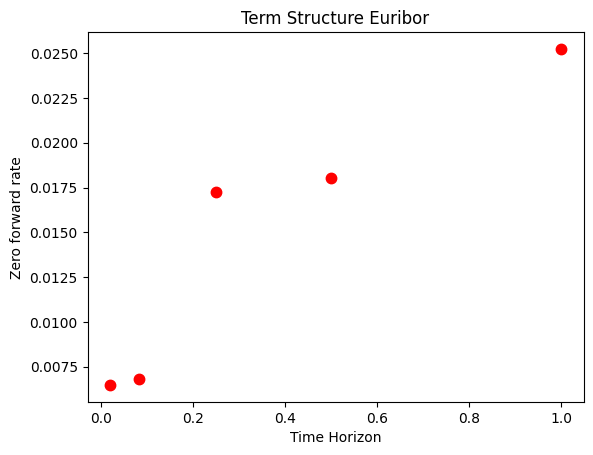

In [172]:
r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)

plt.plot(mat_list, zero_rates, "r.", markersize="15")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.show()

In [173]:
bspline = splrep(mat_list, zero_rates, k=3)  # Cubic spline
mat_list_n = np.linspace(
    0.0, 1.0, 24
)  # Create 24 equally spaced maturities between 0 and 1
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
f = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative

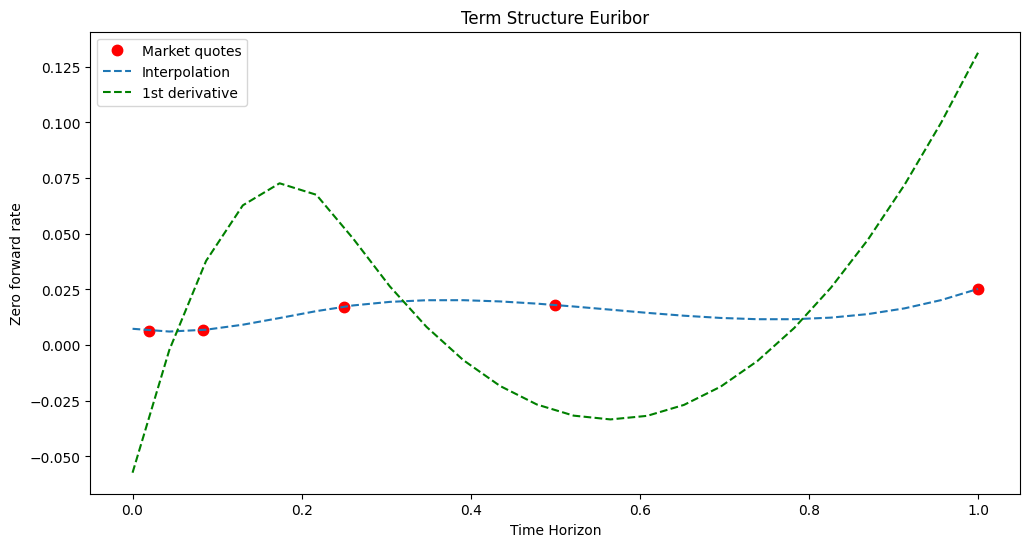

In [174]:
plt.figure(figsize=(12, 6))
plt.plot(mat_list, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(mat_list_n, inter_rates, "--", markersize="10", label="Interpolation")
plt.plot(mat_list_n, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

In [175]:
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2

In [176]:
def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

In [177]:
def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

In [178]:
params_CIR = CIR_calibration()
params_CIR

Optimization terminated successfully.
         Current function value: 0.001204
         Iterations: 198
         Function evaluations: 363


array([0.69193133, 0.19253942, 0.51618613])

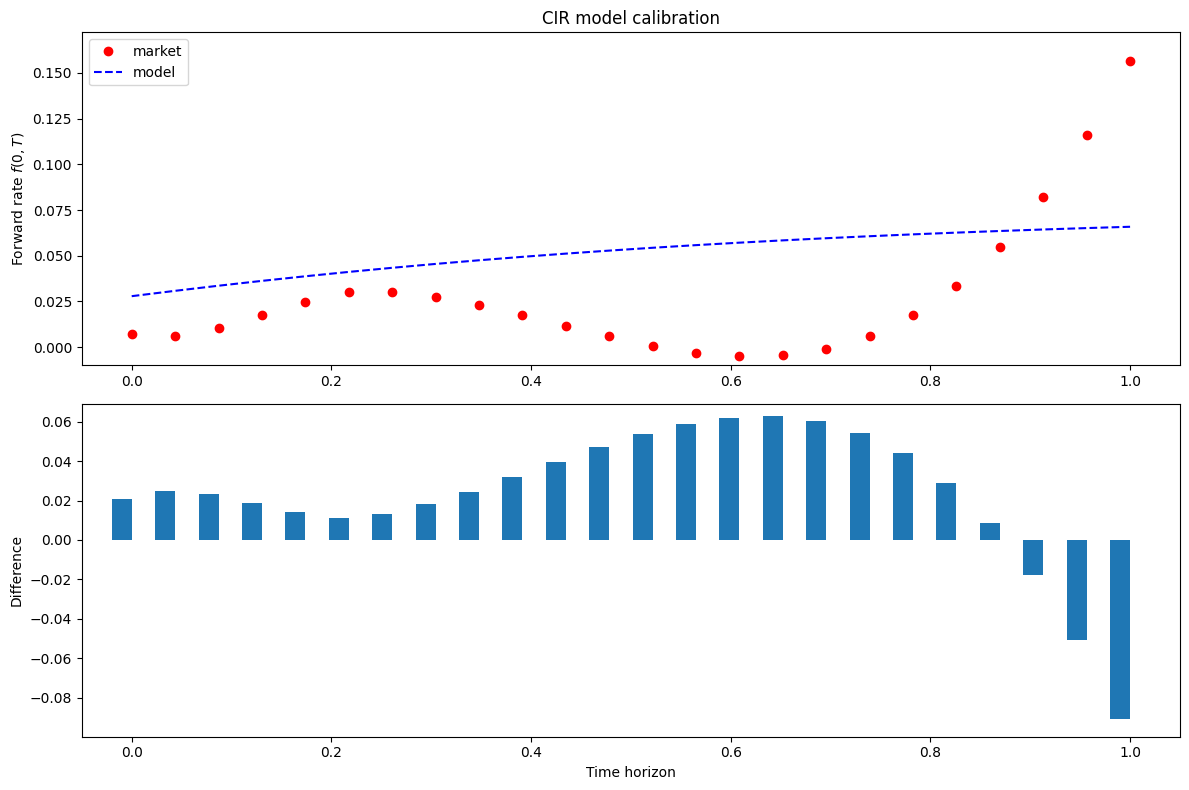

In [189]:
def plot_calibrated_frc(params_CIR):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(params_CIR)
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()

plot_calibrated_frc(params_CIR)

## b. Simulate Euribor 12-month rates daily for a period of 1 year.

In [179]:
kappa_r, theta_r, sigma_r = params_CIR

In [180]:
N = 100       # Time steps
M = 100000    # Number of Simulations
T = 1         # 1 year
r0 = 0.02556 # Euribor 12-month rates

In [181]:
def cir(r0, k, theta, sigma, T, N, M):
    dt = T / N
    rates = np.zeros((N, M))
    rates[0, :] = r0
    for j in range(M):
        for i in range(1, N):
            dr = (
                k * (theta - rates[i - 1, j]) * dt
                + sigma
                * np.sqrt(dt)
                * np.sqrt(np.maximum(rates[i - 1, j], 0))
                * np.random.normal()
            )
            rates[i, j] = rates[i - 1, j] + dr
    return rates

In [182]:
rates_cir = cir(r0, kappa_r, theta_r, sigma_r, T, N, M)

### Plot the interest rate:

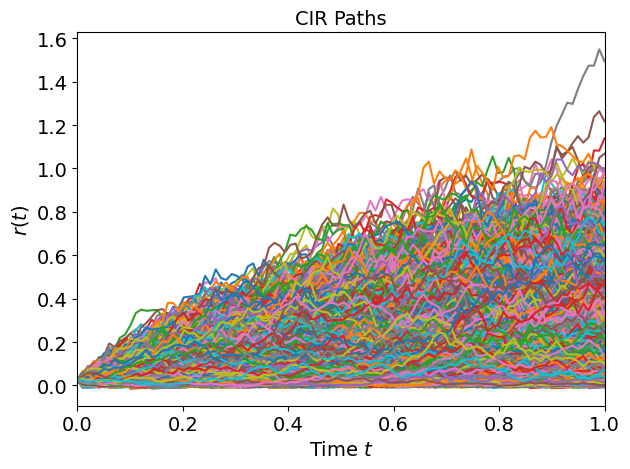

In [183]:
t = np.linspace(0, T, N)

for j in range(M):
    plt.plot(t, rates_cir[:, j])

plt.xlabel("Time $t$", fontsize=14)
plt.ylabel("$r(t)$", fontsize=14)
plt.title("CIR Paths", fontsize=14)
axes = plt.gca()
axes.set_xlim([0, T])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

### i) Select a level of confidence you are comfortable with, which is the range (max and min) that the 12-month Euribor can take in the next year?

In [184]:
rates_cir[99,:]

array([0.02325706, 0.07407261, 0.01543518, ..., 0.08038947, 0.10898153,
       0.07008001])

In [185]:
min(rates_cir[99,:])

-0.008179153204709511

In [186]:
max(rates_cir[99,:])

1.4927497910631367

We can find the minimum, and maximum 12-month Euribor, by comparing the estimated interest rates at the final step of the simulation. We use a 95% confidence interval to visualize it.

### ii) What is the expected value of the 12-month Euribor in 1 year?

In [187]:
np.mean(rates_cir[99,:])

0.10817829123323021